In [2]:
import sys
sys.path.append("..")
import h5py
from tqdm import tqdm
# import imageio
import io

import torch
from torch.utils.data import DataLoader
import numpy as np
import pytorch_lightning as pl
from torchmetrics import MeanSquaredError
from scipy.stats import binned_statistic

from coda.datamodule.DataLoader import L96InferenceDataset
from coda.datamodule.observational_models import RandomObservationModel
from mdml_tools.simulators.lorenz96 import L96Simulator

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()
# SMALL_SIZE = 13
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 16
#
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# Set random seed for reproducibility
pl.seed_everything(1000)
# choose device. GPU is default if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Seed set to 1000


In [5]:
# path to training and test data
train_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/training/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
# path to assimilation network checkpoint
pretrained_network_checkpoint = "/gpfs/work/zinchenk/final_experiments/140424_imperfect_forward_operator/pretrain_data_assimilation/multirun/2024-03-14/03-19-59/0/logs/checkpoints/assimilation_network.ckpt"
trained_network_checkpoint = "/gpfs/work/zinchenk/final_experiments/300424_parametrization_learning/parametrization_learning/multirun/2024-04-30/13-17-52/0/logs/checkpoints/assimilation_network.ckpt"
# path to simulator checkpoint with coupled parametrization
simulator_checkpoint = "/gpfs/work/zinchenk/final_experiments/300424_parametrization_learning/parametrization_learning/multirun/2024-04-30/13-17-52/0/logs/checkpoints/simulator.ckpt"

In [6]:
train_data = {}
with h5py.File(train_data_path, "r") as file:
    train_data["first_level"] = torch.tensor(file["first_level"][:][0], device=device, requires_grad=False)
    train_data["second_level"] = torch.tensor(file["second_level"][:][0], device=device, requires_grad=False)

In [7]:
test_data = {}
with h5py.File(test_data_path, "r") as file:
    test_data["first_level"] = torch.tensor(file["first_level"][:], device=device, requires_grad=False)
    test_data["second_level"] = torch.tensor(file["second_level"][:], device=device, requires_grad=False)

In [8]:
pretrained_network = torch.load(pretrained_network_checkpoint, map_location=device)
trained_network = torch.load(trained_network_checkpoint, map_location=device)
ground_truth = test_data["first_level"]

In [9]:
# instantiate observational model
observational_model = RandomObservationModel(
    additional_noise_std=1.0,
    random_mask_fraction=0.75,
)

# instantiate dataset
loader = L96InferenceDataset(
    ground_truth_data=ground_truth.to("cpu"),
    observation_model=observational_model,
    input_window_extend=25,
    drop_edge_samples=True,
)
loader.to(device)

In [ ]:
reconstruction = {"no_param": [], "param": []}

for batch in tqdm(loader):
    with torch.no_grad():
        state = pretrained_network.forward(batch)
        reconstruction["no_param"].append(state)
        state = trained_network.forward(batch)
        reconstruction["param"].append(state)

reconstruction["no_param"] = torch.concat(reconstruction["no_param"], dim=1)
reconstruction["param"] = torch.concat(reconstruction["param"], dim=1)

 13%|█████▎                                   | 124/951 [01:22<10:01,  1.37it/s]

In [10]:
path_to_file = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/training/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
with h5py.File(path_to_file, 'r') as file:
    x = file["first_level"][:][0]
    y = file["second_level"][:][0]
    x = torch.tensor(x)
    y = torch.tensor(y)

In [11]:
h, c, b = 10, 1, 10
hcb = (h * c) / b

correction_term = []
for i in range(y.size(0)):
    y_summed = y[i].reshape((36, 10)).sum(dim=-1)
    term = -hcb * y_summed
    correction_term.append(term)
correction_term = torch.stack(correction_term)

In [12]:
y_plot = correction_term.flatten()
x_plot = x.flatten()

Text(0, 0.5, '$B_{\\psi}(x_k)$')

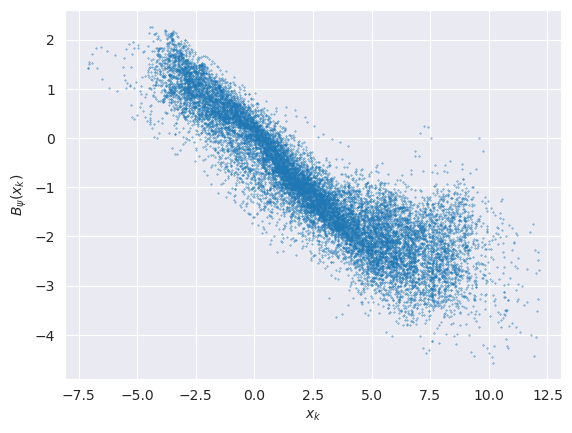

In [13]:
n_points = 15000
plt.scatter(x_plot[:n_points], y_plot[:n_points], s=0.1, label="ground truth")

plt.xlabel(r"$x_k$")
plt.ylabel(r"$B_{\psi}(x_k)$")

In [14]:
y_plot = correction_term.flatten()
x_plot = x.flatten()

mean, bin_edges, _ = binned_statistic(x_plot, y_plot, bins=10)
std, _, _ = binned_statistic(x_plot, y_plot, bins=10, statistic="std")
count, _, _ = binned_statistic(x_plot, y_plot, bins=10, statistic="count")

bin_centers = np.convolve(bin_edges, np.ones(2)/2, mode='valid')
sem = std / np.sqrt(count)

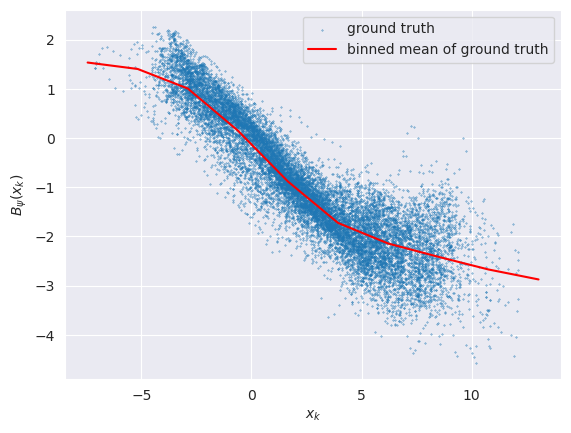

In [15]:
n_points = 15000
plt.scatter(x_plot[:n_points], y_plot[:n_points], s=0.1, label="ground truth")
plt.plot(bin_centers, mean, color="red", label="binned mean of ground truth")


plt.xlabel(r"$x_k$")
plt.ylabel(r"$B_{\psi}(x_k)$")
plt.legend()

In [16]:
path = "/gpfs/work/zinchenk/final_experiments/300424_parametrization_learning/parametrization_learning/multirun/2024-04-30/13-17-52/0/logs/checkpoints/simulator.ckpt"

In [17]:
simulator = torch.load(path, map_location=device)
parametrization = simulator.parametrization

In [18]:
# x_in = torch.linspace(bin_centers[0], bin_centers[-1], 100).unsqueeze(0).unsqueeze(0)
x_in = torch.tensor(bin_centers).unsqueeze(0).unsqueeze(0).float().to(device)
with torch.no_grad():
    b_out = parametrization.forward(x_in)

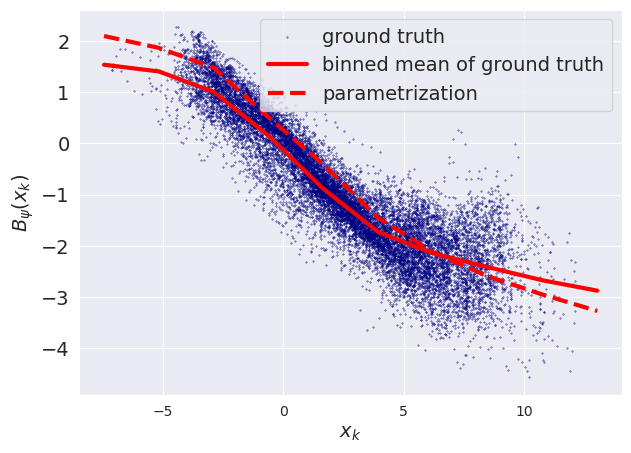

In [19]:
n_points = 15000
fig = plt.figure(figsize=(7, 5), facecolor="white")
plt.scatter(x_plot[:n_points], y_plot[:n_points], s=0.1, label="ground truth", color="navy")
plt.plot(bin_centers, mean, color="red", label="binned mean of ground truth", lw=3)
plt.plot(x_in.squeeze().detach().to("cpu").numpy(), b_out.squeeze().detach().to("cpu").numpy(), color="red", ls="--", lw=3, label="parametrization")


plt.yticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r"$x_k$", fontsize=14)
plt.ylabel(r"$B_{\psi}(x_k)$", fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("input_output_function.png", dpi=300)

In [20]:
end_point = 500
initial_states = test_data["first_level"][:, 0, :].unsqueeze(1)

two_level_simulations = test_data["first_level"][:, :end_point, :]

time = torch.arange(0, end_point*0.01, 0.01).to(device)
simulator_one = L96Simulator(forcing=10)

one_level_simulations = simulator_one.integrate(time, initial_states).squeeze().to("cpu")
nn_parametrized_simulations = simulator.integrate(time, initial_states).squeeze().detach()

squared_error = (two_level_simulations - one_level_simulations)**2
one_level_simulations_rmse_m = torch.sqrt(squared_error.mean(dim=(-1))).mean(dim=(0))
one_level_simulations_rmse_s = torch.sqrt(squared_error.mean(dim=(-1))).std(dim=(0))

squared_error = (two_level_simulations - nn_parametrized_simulations)**2
nn_parametrized_simulations_rmse_m = torch.sqrt(squared_error.mean(dim=(-1))).mean(dim=(0))
nn_parametrized_simulations_rmse_s = torch.sqrt(squared_error.mean(dim=(-1))).std(dim=(0))

In [21]:
simtrue = x[0:end_point, :]

simulator_one = L96Simulator(forcing=10)
x_input = x[0, :].unsqueeze(0).unsqueeze(0).to(device)
time = torch.arange(0, end_point*0.01, 0.01).to(device)
simone = simulator_one.integrate(time, x_input).squeeze().to("cpu")

simpar = simulator.integrate(time, x_input).squeeze().detach()

In [22]:
x_true = two_level_simulations[:, 25:].flatten()
x_hat = reconstruction["param"][:, :end_point-25].flatten()
with torch.no_grad():
    b_of_x_hat = parametrization.forward(x_hat.unsqueeze(0).unsqueeze(0).to(device)).squeeze().detach().to("cpu")

In [23]:
hat_mean, hat_bin_edges, _ = binned_statistic(x_true, b_of_x_hat, bins=10)
hat_bin_centers = np.convolve(bin_edges, np.ones(2)/2, mode='valid')

In [24]:
time_ticks = np.arange(0, end_point+1, 100)
time_ticks_labels = time_ticks * 0.01

In [38]:
mosaic = """
aabbcc
dddeee
"""

fig, axd = plt.subplot_mosaic(mosaic, figsize=(10, 6), facecolor="white", constrained_layout=True)

limit = torch.stack([simtrue.to("cpu").abs(), simone.to("cpu").abs(), simpar.to("cpu").abs()]).max()
img0 = axd["a"].pcolor(simtrue.to("cpu").T, vmin=-limit, vmax=limit, cmap="viridis")
img1 = axd["b"].pcolor(simpar.to("cpu").T, vmin=-limit, vmax=limit, cmap="viridis")
img2 = axd["c"].pcolor(simone.to("cpu").T, vmin=-limit, vmax=limit, cmap="viridis")
axd["a"].set_ylabel(r"location")

for letter in ["a", "b", "c"]:
    axd[letter].set_xticks(time_ticks, time_ticks_labels)
    axd[letter].set_yticks([])


axd["d"].plot(one_level_simulations_rmse_m, scaley="log", color="blue", label="no param.")
axd["d"].plot(one_level_simulations_rmse_m-one_level_simulations_rmse_s, scaley="log", color="blue", ls="--")
axd["d"].plot(one_level_simulations_rmse_m+one_level_simulations_rmse_s, scaley="log", color="blue", ls="--")
axd["d"].plot(nn_parametrized_simulations_rmse_m, scaley="log", color="orange", label="nn param")
axd["d"].plot(nn_parametrized_simulations_rmse_m-nn_parametrized_simulations_rmse_s, scaley="log", color="orange", ls="--")
axd["d"].plot(nn_parametrized_simulations_rmse_m+nn_parametrized_simulations_rmse_s, scaley="log", color="orange", ls="--")
axd["d"].set_xticks(time_ticks, time_ticks_labels)
axd["d"].set_xlabel(r"time")
axd["d"].set_ylabel(r"RMSE")
axd["d"].legend()


img3 = axd["e"].scatter(x_plot[:n_points], y_plot[:n_points], s=0.1, label=r"$hc\overline{z}$", color="navy")
img4 = axd["e"].plot(bin_centers, mean, color="red", label=r"$\mathbb{E}[hc\overline{z}|x]$", lw=3)
img6 = axd["e"].plot(hat_bin_centers, hat_mean, color="orange", label=r"$\mathbb{E}[\mathcal{B}_\psi(\tilde{x})|x]$", lw=3)
img5 = axd["e"].plot(x_in.squeeze().detach().to("cpu").numpy(), b_out.squeeze().detach().to("cpu").numpy(), color="red", ls=":", lw=3, label=r"$\mathbb{E}[\mathcal{B}_\psi(x)]$")

axd["e"].set_xlabel(r"$x_k$")
# axd["e"].set_ylabel(r"$\mathcal{B}_{\psi}(x_k)$")
axd["e"].legend()


for key, ax in axd.items():
    if key == "a":
        title = f"{key}) L96 two-level"
    elif key == "b":
        title = f"{key}) L96 NN parametrization"
    elif key == "c":
        title = f"{key}) L96 truncated"
    else:    
        title = f"{key})"
    ax.set_title(title, loc='left', fontsize=13, fontweight="bold")


plt.savefig("fig_6.png", dpi=300)